In this project, we developed a system to classify financial sentiment related texts. We started by establishing a baseline model using Logistic Regression. This simple yet effective model allowed us to set a foundation for comparison with more complex models.

Next, we compared the baseline with a variety of more advanced models, including Random Forest, XGBoost, SVM, and Multi-Layer Perceptron (MLP). Each of these models was evaluated for their performance on the text classification task. For text representation, we explored several different approaches, including NGram, TF-IDF, Word2Vec, and BERT vector embeddings. These methods provided varied ways to represent the textual data and helped to capture different aspects of the text.

After building the models, we fine-tuned each one by adjusting hyperparameters such as tree depth for decision tree-based models, learning rate for boosting models, regularization parameters, and hidden layer sizes for neural network-based models like MLP. These adjustments were made using GridSearchCV to find the optimal settings for each model.

To better understand and prepare the data, we performed various data visualizations, including label distribution tables, word clouds, bar charts, and analysis of high-frequency words. We also computed summary statistics like sentence length and variance. These visualizations and statistics helped improve the overall quality of text preprocessing.

After summarizing and comparing the results from these models, we identified that the performance was still not optimal. As a result, we decided to further optimize the models using Stacking and Grid Search + Cross Validation. In addition, we applied domain-specific sentiment word extraction using the Loughran-McDonald financial dictionary, which significantly improved the model's accuracy and performance compared to the baseline.

Throughout the project, we adhered to a standardized data split of 80% training and 20% testing, with the evaluation metric being accuracy to ensure consistent and reliable results.

# MLP

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import ast

spark = SparkSession.builder.appName("TextEmbeddings").getOrCreate()

df = spark.read.csv("processed_data6Financial.csv", header=True, inferSchema=True)

# Convert Sentiment_Words to array<string>
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

def parse_tokens(text):
    return ast.literal_eval(text)

parse_udf = udf(parse_tokens, ArrayType(StringType()))
df = df.withColumn("words", parse_udf(col("Sentiment_Words")))

df.select("PhraseId", "Sentiment", "words").show(3, truncate=False)

+--------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------+
|PhraseId|Sentiment|words                                                                                                                                             |
+--------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------+
|110715  |0        |[poor, remake, well, loved, classic, exposes, limitations, skill, basic, flaws, vision]                                                           |
|135234  |0        |[without, redeeming, value, whatsoever]                                                                                                           |
|73266   |0        |[cheap, scam, put, together, cynical, creeps, revolution, studios, imagine, entertainment, make, suckers, surrender, minutes, unrecoverable,

In [3]:
from pyspark.ml.feature import CountVectorizer, IDF

# Count Vectorizer
cv = CountVectorizer(inputCol="words", outputCol="raw_features")
cv_model = cv.fit(df)
featurized_df = cv_model.transform(df)

# IDF
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(featurized_df)
tfidf_df = idf_model.transform(featurized_df)

tfidf_df.select("Sentiment", "tfidf_features").show(2, truncate=False)

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentiment|tfidf_features                                                                                                                                                                                                                                                   |
+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |(3829,[17,325,484,554,615,893,1292,2001,3158,3417,3787],[3.713572066704308,5.3230099791384085,5.546153530452618,5.546153530452618,5.546153530452618,5.833835602904399,5.83383560290

In [4]:
from pyspark.ml.feature import Word2Vec

word2Vec = Word2Vec(vectorSize=100, minCount=1, inputCol="words", outputCol="w2v_features")
w2v_model = word2Vec.fit(df)
w2v_df = w2v_model.transform(df)

w2v_df.select("Sentiment", "w2v_features").show(2, truncate=False)

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
from pyspark.ml.feature import NGram

ngram = NGram(n=2, inputCol="words", outputCol="ngrams")
ngram_df = ngram.transform(df)

ngram_df.select("Sentiment", "ngrams").show(2, truncate=False)

+---------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentiment|ngrams                                                                                                                                                |
+---------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[poor remake, remake well, well loved, loved classic, classic exposes, exposes limitations, limitations skill, skill basic, basic flaws, flaws vision]|
|0        |[without redeeming, redeeming value, value whatsoever]                                                                                                |
+---------+------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 2 row

In [6]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
from pyspark.sql.types import StructType, StructField, IntegerType, ArrayType, FloatType

# Load the BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Enable GPU for acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Extract PhraseId, Sentiment, and words as a Python list
data = df.select("PhraseId", "Sentiment", "words").rdd.map(lambda row: (row["PhraseId"], row["Sentiment"], row["words"])).collect()

# Define BERT embedding function (using [CLS] vector + preventing empty list)
def get_bert_embedding(tokens):
    if not tokens:
        return [0.0] * 768
    encoded = tokenizer(" ".join(tokens), return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        output = model(**encoded)
    return output.last_hidden_state[:, 0, :].squeeze().cpu().tolist()  # Use [CLS] token

# Get embeddings
bert_rows = [(pid, sentiment, get_bert_embedding(tokens)) for pid, sentiment, tokens in data]

# Convert to Pandas DataFrame
bert_df = pd.DataFrame(bert_rows, columns=["PhraseId", "Sentiment", "bert_features"])

# Convert to Spark DataFrame
schema = StructType([
    StructField("PhraseId", IntegerType(), True),
    StructField("Sentiment", IntegerType(), True),
    StructField("bert_features", ArrayType(FloatType()), True)
])
bert_spark_df = spark.createDataFrame(bert_df, schema)

# Display samples
bert_spark_df.select("PhraseId", "Sentiment", "bert_features").show(3, truncate=25)

# Merge back to the original DataFrame
final_df = df.join(bert_spark_df.select("PhraseId", "bert_features"), on="PhraseId", how="inner")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

+--------+---------+-------------------------+
|PhraseId|Sentiment|            bert_features|
+--------+---------+-------------------------+
|  110715|        0|[-0.72784454, -0.20394...|
|  135234|        0|[-0.3907133, 0.0643522...|
|   73266|        0|[0.0936385, 0.03911782...|
+--------+---------+-------------------------+
only showing top 3 rows



In [7]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

def train_evaluate_mlp(input_df, feature_col, label_col="Sentiment", layers=[100, 64, 5], label_indexed=False):
    # Feature assembler (vector format)
    assembler = VectorAssembler(inputCols=[feature_col], outputCol="features")

    # MLP model: input -> hidden layers -> output (5 classes)
    mlp = MultilayerPerceptronClassifier(
        featuresCol="features",
        labelCol=label_col,
        predictionCol="prediction",
        maxIter=100,
        layers=layers,
        blockSize=128,
        seed=42
    )

    # Pipeline
    pipeline = Pipeline(stages=[assembler, mlp])

    # Split into training and testing sets
    train_df, test_df = input_df.randomSplit([0.8, 0.2], seed=42)

    # Training
    model = pipeline.fit(train_df)

    # Prediction
    result = model.transform(test_df)

    # Evaluation
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    acc = evaluator.evaluate(result)
    print(f"Accuracy ({feature_col}): {acc:.4f}")
    return acc

In [8]:
from pyspark.ml.feature import CountVectorizer, IDF

# Convert n-gram column to term frequency vector
ngram_cv = CountVectorizer(inputCol="ngrams", outputCol="ngram_raw")
ngram_cv_model = ngram_cv.fit(ngram_df)
ngram_feat_df = ngram_cv_model.transform(ngram_df)

# Convert to TF-IDF
idf_ngram = IDF(inputCol="ngram_raw", outputCol="ngram_features")
idf_ngram_model = idf_ngram.fit(ngram_feat_df)
ngram_final_df = idf_ngram_model.transform(ngram_feat_df)

# NGram-based Model training
train_evaluate_mlp(ngram_final_df, feature_col="ngram_features", layers=[ngram_final_df.select("ngram_features").first()[0].size, 32, 5])

Accuracy (ngram_features): 0.2781


0.2781065088757396

In [12]:
# TFIDF-based Model training
train_evaluate_mlp(tfidf_df, feature_col="tfidf_features", layers=[tfidf_df.select("tfidf_features").first()[0].size, 128, 5])

# W2V-based Model training
train_evaluate_mlp(w2v_df, feature_col="w2v_features", layers=[100, 8, 5])

Accuracy (tfidf_features): 0.3077
Accuracy (w2v_features): 0.3077


0.3076923076923077

In [10]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# Convert bert_features from array<float> to Vector
to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())
bert_df_vec = final_df.withColumn("bert_vector", to_vector_udf("bert_features"))

# Call the pipeline function for training and evaluation
train_evaluate_mlp(bert_df_vec, feature_col="bert_vector", layers=[768, 256, 128, 5])

Accuracy (bert_vector): 0.3368


0.3368421052631579

<ipython-input-13-07256a5dd98f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=methods, y=accuracies, palette="Blues_d")


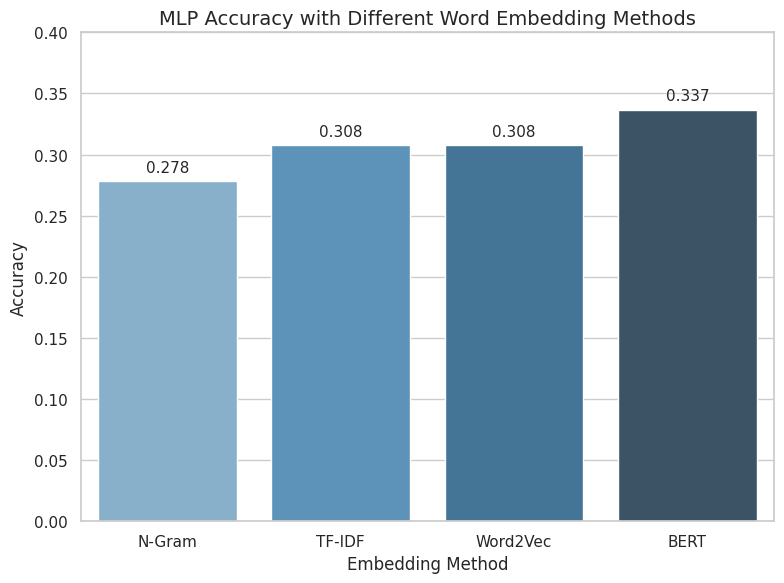

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

methods = ["N-Gram", "TF-IDF", "Word2Vec", "BERT"]
accuracies = [0.2781, 0.3077, 0.3077, 0.3368]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
bars = sns.barplot(x=methods, y=accuracies, palette="Blues_d")

for bar, acc in zip(bars.patches, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{acc:.3f}", ha='center', va='bottom', fontsize=11)

plt.title("MLP Accuracy with Different Word Embedding Methods", fontsize=14)
plt.xlabel("Embedding Method")
plt.ylabel("Accuracy")
plt.ylim(0, 0.4)
plt.tight_layout()
plt.show()

# Visualization (Data Preprocessing)

In [15]:
# Sentiment Label Distribution

df = pd.read_csv('processed_data6Financial.csv')
df['Phrase_Len'] = df['Phrase'].apply(lambda x: len(str(x).split()))

label_meaning = {
    0: 'Negative',
    1: 'Somewhat Negative',
    2: 'Mix-Sentiment',
    3: 'Somewhat Positive',
    4: 'Positive'
}

results = []
total = len(df)

# Traverse each label
for label in sorted(df['Sentiment'].unique()):
    subset = df[df['Sentiment'] == label]
    count = len(subset)
    percent = f"{(count / total * 100):.1f}%"
    avg_len = round(subset['Phrase_Len'].mean(), 1)
    max_len = subset['Phrase_Len'].max()
    min_len = subset['Phrase_Len'].min()

    results.append({
        'Label': label,
        'Meaning': label_meaning.get(label, ''),
        'Count': count,
        '%': percent,
        'Avg Len': avg_len,
        'Max Len': max_len,
        'Min Len': min_len
    })

summary_df = pd.DataFrame(results)
print(summary_df)

   Label            Meaning  Count      %  Avg Len  Max Len  Min Len
0      0           Negative    130  12.7%     19.3       51        3
1      1  Somewhat Negative    262  25.6%     18.9       48        3
2      2      Mix-Sentiment    197  19.2%     18.4       48        1
3      3  Somewhat Positive    281  27.4%     19.8       51        1
4      4           Positive    154  15.0%     19.3       47        4


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


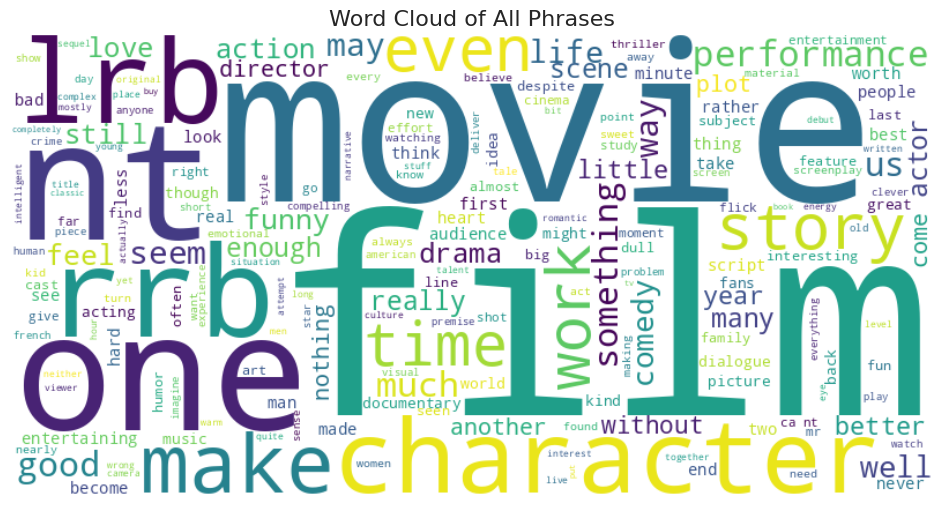

In [18]:
# Word Cloud of All Phrases (Before data preprocessing)
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df["Clean_Tokens"] = df["Phrase"].apply(preprocess_text)

all_tokens = [word for tokens in df["Clean_Tokens"] for word in tokens]

text = " ".join(all_tokens)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of All Phrases", fontsize=16)
plt.show()

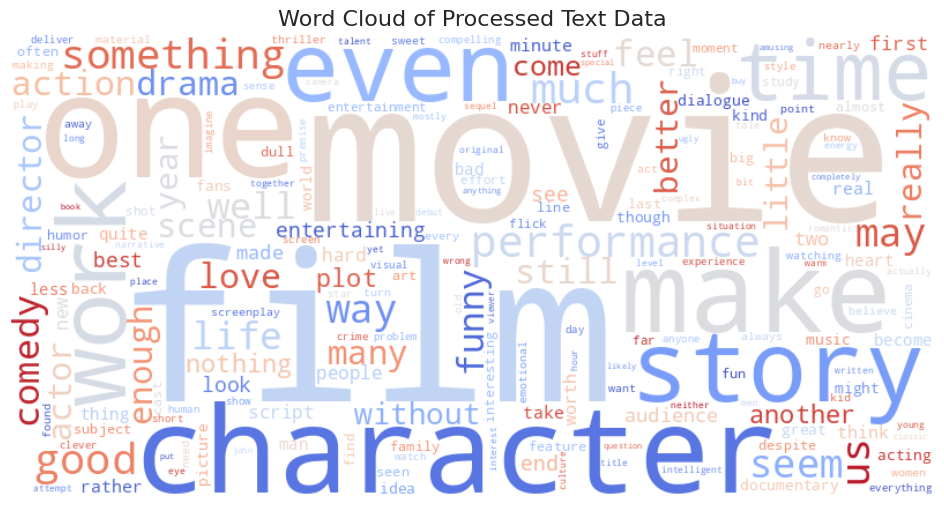

In [19]:
# Word Cloud of Processed Text Data (After data preprocessing)
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import ast

df = pd.read_csv("processed_data6Financial.csv")
df["Sentiment_Words"] = df["Sentiment_Words"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
all_words = [word for word_list in df["Sentiment_Words"] for word in word_list]

text = " ".join(all_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='coolwarm',
    max_words=200
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Text Data", fontsize=16)
plt.show()